In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sksurv.util import Surv 
from sklearn.model_selection import train_test_split

In [2]:
import yaml
import sys
sys.path.append('/home/gmarinos/Documents/Code/Survival_analysis_exceedance_forecasting/src')
 
from src.synthetic_data_generation.synthetic_data_generation import *
from src.utils.utils import *
from src.data_fetching.data_fetching import *
from src.dataset_construction.dataset_construction import *


# Step 1: Parse the YAML file
with open('config.yaml', 'r') as file:
    config_data = yaml.safe_load(file)


###Data API

apikey = config_data['apikey']

headers = config_data['headers']

search_endpoint = config_data['search_endpoint']

data_dir = config_data['data_dir']

    
###CONFIGURATION

data_ingredient = config_data['data_requests']['data_ingredient']

predictions_ingredient = config_data['data_requests']['predictions_ingredient']

data_hazard = config_data['data_requests']['data_hazard']

predictions_hazard = config_data['data_requests']['predictions_hazard']



#####

THRESHOLD_PERCENTILE = config_data['THRESHOLD_PERCENTILE']

timesteps = config_data['timesteps']

random_state = config_data['random_state']

Column_name = config_data['Column_name']

test_size_ = config_data['test_size_']

shuffle_ = config_data['shuffle_']

invalid_observations_removal_ = config_data['invalid_observations_removal']

interval = config_data['interval'] 

starting_date = config_data['starting_date']

end_date = config_data['end_date']

validation_rows = len(data_prediction_request(apikey, headers, search_endpoint, data_dir, predictions_ingredient, predictions_hazard, interval, starting_date, end_date))

In [3]:
#get the data
data = data_request(apikey, headers, search_endpoint, data_dir, data_ingredient, data_hazard, interval, starting_date, end_date, plot=True)
prophet_predictions = data_prediction_request(apikey, headers, search_endpoint, data_dir, predictions_ingredient, predictions_hazard, interval, starting_date, end_date)
print(data)
print(prophet_predictions)

        Date  Incidents
0    2000-01          6
1    2000-02          5
2    2000-03         14
3    2000-04          8
4    2000-05          8
..       ...        ...
275  2022-12         48
276  2023-01         59
277  2023-02         98
278  2023-03         70
279  2023-04        105

[280 rows x 2 columns]
            Predicted_value
Date                       
2021-10-01        60.671082
2021-11-01        61.374947
2021-12-01        58.511398
2022-01-01        65.395554
2022-02-01        75.000000
2022-03-01        68.000000
2022-04-01       107.000000
2022-05-01        59.000000
2022-06-01        84.000000
2022-07-01        56.474709
2022-08-01        58.747616
2022-09-01        91.009193
2022-10-01        67.246376
2022-11-01        58.347767
2022-12-01        87.267227
2023-01-01        71.294487
2023-02-01        93.305328
2023-03-01        61.318035
2023-04-01        81.011528


In [5]:
from src.data_preprocessing import DataPreprocessor 
from src.model_trainning_and_evaluation import ModelEvaluator

# Create an instance of the DataPreprocessing class
data_processor = DataPreprocessor(data, apikey, headers, search_endpoint,
                 data_dir, data_ingredient, predictions_ingredient, data_hazard, predictions_hazard,
                 THRESHOLD_PERCENTILE, timesteps, random_state, Column_name, test_size_, shuffle_,
                 invalid_observations_removal_, interval, starting_date, end_date)

# Step 1: Data Preprocessing
X, y = data_processor.create_supervised_data()

# Step 2: Train-Test Split
test_size_ = 0.2  # Set your test size
X_train, X_test, y_train, y_test, THRESHOLD, X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat = data_processor.train_test_split(test_size_)

# Step 3: Invalid Observations Removal (optional)
invalid_observations_removal_ = False  # Set to True if you want to remove invalid observations
X_train, X_test, y_train, y_test = data_processor.invalid_observations_removal(X_train, X_test, y_train, y_test, THRESHOLD, invalid_observations_removal_)

            Incidents  extreme_event
Date                                
2000-01-01          6              0
2000-02-01          5              0
2000-03-01         14              0
2000-04-01          8              0
2000-05-01          8              0
...               ...            ...
2022-12-01         48              0
2023-01-01         59              0
2023-02-01         98              1
2023-03-01         70              0
2023-04-01        105              1

[280 rows x 2 columns]
            Incidents  extreme_event
Date                                
2000-01-01          6              0
2000-02-01          5              0
2000-03-01         14              0
2000-04-01          8              0
2000-05-01          8              0
...               ...            ...
2022-12-01         48              0
2023-01-01         59              0
2023-02-01         98              1
2023-03-01         70              0
2023-04-01        105              1

[280 rows x 2

In [6]:
model_evaluator = ModelEvaluator(data, 
                                  X_train, X_test, y_train, y_test, THRESHOLD, X_train_survival, X_test_survival, y_train_survival, y_test_survival, X_train_survival_ext_feat, X_test_survival_ext_feat, y_train_survival_ext_feat, y_test_survival_ext_feat,
                                  Column_name, timesteps, THRESHOLD_PERCENTILE,
                                   validation_rows, random_state, test_size_, shuffle_,
                                   invalid_observations_removal_, Column_name, interval, data_ingredient, 
                                   predictions_ingredient, data_hazard, predictions_hazard)

In [7]:
table_data = model_evaluator.evaluate_models()
model_evaluator.print_results()



Distribution: genextreme
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[23  8]
 [18  6]]
Accuracy: 0.53
Precision: 0.43
Recall: 0.25
F1 Score: 0.32
Roc AUC: 0.67


Distribution: norm
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 [18  6]]
Accuracy: 0.62
Precision: 0.67
Recall: 0.25
F1 Score: 0.36
Roc AUC: 0.67


Distribution: laplace
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 [18  6]]
Accuracy: 0.62
Precision: 0.67
Recall: 0.25
F1 Score: 0.36
Roc AUC: 0.67


Distribution: logistic
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 [18  6]]
Accuracy: 0.62
Precision: 0.67
Recall: 0.25
F1 Score: 0.36
Roc AUC: 0.67


Distribution: gumbel_r
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[23  8]
 [18  6]]
Accuracy: 0.53
Precision: 0.43
Recall: 0.25
F1 Score: 0.32
Roc AUC: 0.67


Distribution: lognorm
Model: DecisionTreeRegressor(random_state=33)
Confusion Matrix:
[[28  3]
 

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:3263: RuntimeWarning: overflow encountered in exp
  return np.exp(-np.exp(-x))


Confusion Matrix:
[[19 12]
 [ 7 17]]
Accuracy: 0.65
Precision: 0.59
Recall: 0.71
F1 Score: 0.64
Roc AUC: 0.80


Distribution: norm
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [21  3]]
Accuracy: 0.60
Precision: 0.75
Recall: 0.12
F1 Score: 0.21
Roc AUC: 0.80


Distribution: laplace
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [21  3]]
Accuracy: 0.60
Precision: 0.75
Recall: 0.12
F1 Score: 0.21
Roc AUC: 0.80


Distribution: logistic
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [21  3]]
Accuracy: 0.60
Precision: 0.75
Recall: 0.12
F1 Score: 0.21
Roc AUC: 0.80


Distribution: gumbel_r
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[19 12]
 [ 7 17]]
Accuracy: 0.65
Precision: 0.59
Recall: 0.71
F1 Score: 0.64
Roc AUC: 0.80


Distribution: lognorm
Model: AdaBoostRegressor(random_state=33)
Confusion Matrix:
[[30  1]
 [19  5]]
Accuracy: 0.64
Precision: 0.83
Recall: 0.21
F1 Score: 0.33
Roc AUC: 0.79


Distribut

/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Confusion Matrix:
[[31  0]
 [24  0]]
Accuracy: 0.56
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Roc AUC: 0.50


Distribution: logistic
Model: SVR(C=1, gamma=2)
Confusion Matrix:
[[31  0]
 [24  0]]
Accuracy: 0.56
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Roc AUC: 0.50


Distribution: gumbel_r
Model: SVR(C=1, gamma=2)
Confusion Matrix:
[[31  0]
 [24  0]]
Accuracy: 0.56
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Roc AUC: 0.50


Distribution: lognorm
Model: SVR(C=1, gamma=2)
Confusion Matrix:
[[31  0]
 [24  0]]
Accuracy: 0.56
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Roc AUC: 0.50


Distribution: cauchy
Model: SVR(C=1, gamma=2)
Confusion Matrix:
[[31  0]
 [24  0]]
Accuracy: 0.56
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Roc AUC: 0.50


Distribution: genextreme
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[20 11]
 [ 3 21]]
Accuracy: 0.75
Precision: 0.66
Recall: 0.88
F1 Score: 0.75
Roc AUC: 0.79


Distribution: norm
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79


Distribution: laplace
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79


Distribution: logistic
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79


Distribution: gumbel_r
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[20 11]
 [ 3 21]]
Accuracy: 0.75
Precision: 0.66
Recall: 0.88
F1 Score: 0.75
Roc AUC: 0.79


Distribution: lognorm
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[22  9]
 [ 8 16]]
Accuracy: 0.69
Precision: 0.64
Recall: 0.67
F1 Score: 0.65
Roc AUC: 0.78


Distribution: cauchy
Model: MLPRegressor(random_state=33)


/home/gmarinos/Documents/Code/1st_publication/1st_pub/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix:
[[24  7]
 [ 8 16]]
Accuracy: 0.73
Precision: 0.70
Recall: 0.67
F1 Score: 0.68
Roc AUC: 0.79
0.6545454545454545 % 1.0 % 0.20833333333333334 % 0.3448275862068966 % 0.282258064516129 %
0.6727272727272727 % 1.0 % 0.25 % 0.4 % 0.282258064516129 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2264784946236559 %
0.6727272727272727 % 0.8 % 0.3333333333333333 % 0.47058823529411764 % 0.2264784946236559 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2264784946236559 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2264784946236559 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.24731182795698925 %
0.6545454545454545 % 0.8571428571428571 % 0.25 % 0.3870967741935483 % 0.24731182795698925 %
0.6363636363636364 % 0.8333333333333334 % 0.20833333333333334 % 0.33333333333333337 % 0.2547043010752688 %
0.6545454545454545 % 

"| Data                                                                                                            |   Threshold |   Number of lags | Distribution   | Algorithm                                              | Accuracy   | Precision   | Recall   | F1-score   | Roc AUC   |   Test size | Shuffle   | Invalid Observations removal   |   No of Columns | Resolution   |\n|:----------------------------------------------------------------------------------------------------------------|------------:|-----------------:|:---------------|:-------------------------------------------------------|:-----------|:------------|:---------|:-----------|:----------|------------:|:----------|:-------------------------------|----------------:|:-------------|\n| data_ingredient:nuts, nut products and seeds _ predictions_ingredient:nuts, nut products and seeds _ _Incidents |          80 |                6 | genextreme     | DecisionTreeRegressor(random_state=33)                 | 53%        | 43%  

In [8]:
model_evaluator.get_results_df()

Incidents 8260


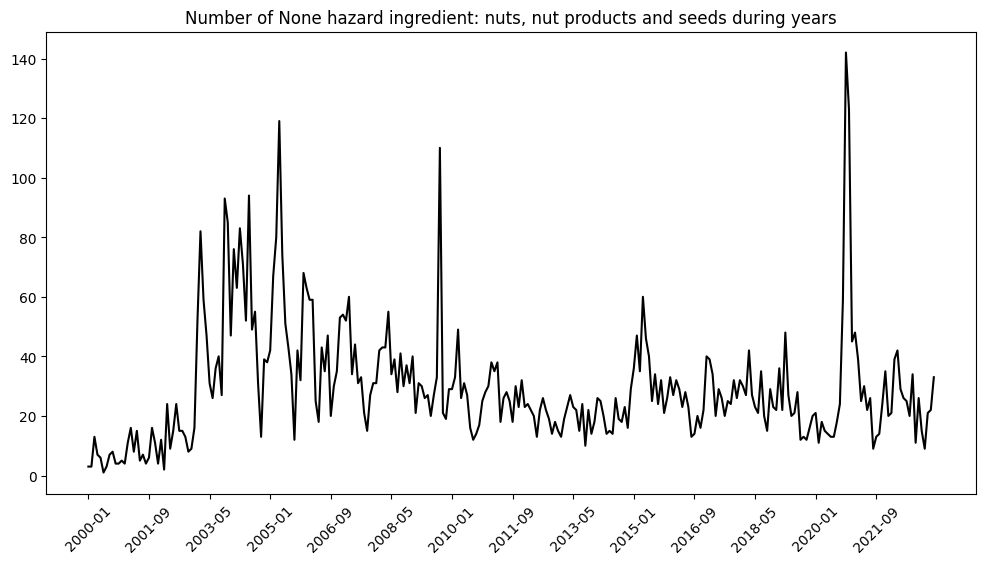

In [6]:
base_request = {
        'apikey': apikey,
        'detail': True,
        'entityType': 'incident',
        'pageSize': 0, #or use 1 here
        'published': True,
        'from': starting_date,
        'to': end_date,
        'strictQuery': {
                'products.value': data_ingredient, 
                'hazards.value': data_hazard,
                #'dataSource': "!!USDA&&!!FDA&&!!Food Safety Authority in China",
                #"origin.value": "europe"
            },
        'aggregations': {
            "date_distribution": {  # distribution of incidents over the years
                "attribute": "createdOn",
                "interval": interval,
                "format": "YYYY-MM",
                "size": 1000
            }
        }
    }

test_data = requests.post(search_endpoint, headers=headers, data=json.dumps(base_request)).json()
#print(json.dumps(data, indent=4))

dataset = {'Date':[], 'Incidents':[]}

for i in json.loads(json.dumps(test_data, indent=4))['aggregations']['date_histogram#date_distribution']['buckets']:
    date = i['key_as_string']
    num = i['doc_count']
    dataset['Date'].append(date)
    dataset['Incidents'].append(num)


data_ = pd.DataFrame(dataset, columns = ['Date', 'Incidents'])

data_ = data_.set_index('Date')
        #data_.to_csv('predictions_.csv')

print('Incidents', data_['Incidents'].sum())

id = [data_.index[i] for i in range(0, len(data_.index), 20)]

plt.figure(figsize=(12,6))
plt.plot(data_.Incidents, color='black')
plt.title('Number of '+str(data_hazard)+' '+str('hazard')+' '+str('ingredient:')+' '+str(data_ingredient)+' during years')
plt.xticks(ticks=id, rotation=45)
#plt.xticks(rotation=45)
#print(data_.Incidents.iloc[-1])
#plt.hlines(y=320, xmin=data_.index[0], xmax=data_.index[-1], color='red', linestyle='--')
plt.show()